In [142]:
from __future__ import division, print_function, unicode_literals
import re
import logging
import operator
import itertools
from collections import Counter
from datetime import timedelta, date
import pandas as pd
import numpy as np
import spacy
from scipy import spatial
import iter8
import liwc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgridspec
plt.style.use('newsprint.mplstyle')

In [2]:
pd.options.display.max_colwidth = 300 # defaults to 50

In [5]:
logging.basicConfig(level=logging.INFO)

In [141]:
# local modules
from presidents import logger, parse_date, tzinfos
from presidents.readers import read_strings, read_ldjson
from presidents.analysis.text import standard_stopwords, tokenize, nlp, parse, is_word
import presidents.analysis.speeches
reload(presidents.analysis.speeches)
from presidents.analysis.speeches import TitledDocument, Speech
from presidents.scraping.tapp import presidents

In [28]:
presidents_lookup = dict(presidents)

In [105]:
liwc_parse_token, liwc_category_names = liwc.load_token_parser('/usr/local/data/liwc_2007.dic')

In [7]:
all_speech_dicts = list(read_ldjson('../data/tapp/all.local-cache.json'))
print('Loaded {} "papers" from TAPP database'.format(len(all_speech_dicts)))

Loaded 128328 "papers" from TAPP database


In [74]:
blacklist_prefixes = (
    'Press Release',
    'Memorandum',
    'Statement by the Press Secretary',
    'Notice',
    'Proclamation',
    'Statement of Administration Policy',
    'Executive Order',
    'Fact Sheet',
    'Press Gaggle', # not so sure about this one, perhaps too broad
)
def is_speech(speech):
    title_is_blacklisted = speech.title.startswith(blacklist_prefixes)
    # exclude speeches that are just a YouTube video; exclude those
    text_is_empty = len(speech.text) == 0
    return not title_is_blacklisted and not text_is_empty

In [30]:
def iter_president_speeches(president):
    pids = list(read_strings('../data/tapp/president/{}.pids'.format(president)))
    logger.info('{} pids for president {}'.format(len(pids), president))
    pidset = set(pids)
    for speech_dict in all_speech_dicts:
        pid = speech_dict['source'].split('=')[-1]
        if pid in pidset:
            speech = Speech(**speech_dict)
            if is_speech(speech):
                yield speech

In [58]:
def calculate_election_day(inaugural_date):
    '''
    figure out election day properly, based on the inaugural date:
    The Tuesday after the first Monday of November
    '''
    year = inaugural_date.year - 1
    november_1 = date(year, 11, 1)
    # weekday() returns 0 for Monday
    first_monday = date(year, 11, 1 + (7 - november_1.weekday()))
    return date(year, 11, first_monday.day + 1)

def _bins_from_inaugural_date(inaugural_date):
    election_date = calculate_election_day(inaugural_date)
    return [
        ('100 days before Election', 
         election_date - timedelta(days=100), election_date),
        ('Election to Inaugural', 
         election_date, inaugural_date),
        ('First 100 days in Office', 
         inaugural_date, inaugural_date + timedelta(days=100)),
        ('Second 100 days in Office', 
         inaugural_date + timedelta(days=100), inaugural_date + timedelta(days=200)),
    ]

def bin_speeches(speeches, inaugural_date):
    '''
    slot speeches into each bin defined by the inaugural_date, 
    
    returns sequence of TitledDocument instances
    '''
    bins = _bins_from_inaugural_date(inaugural_date)
    for title, start, end in bins:        
        bin_speeches = [speech for speech in speeches if start < speech.date <= end]
        # convert each bin of Speech instances into a single string,
        # and then into a spaCy Doc (via the TitledDocument#document property
        bin_text = ' '.join(speech.text for speech in bin_speeches)
        yield TitledDocument(title, bin_text, n_documents=len(bin_speeches))

In [187]:
def iter_similarities(titled_documents, simfunc=lambda d1, d2: d1.document.similarity(d2.document)):
    '''
    titled_documents is a sequence of TitledDocument instances,
    return sequence of (description, similarity) tuples
    '''
    for d1, d2 in iter8.sliding(titled_documents, 2):
        description = '{} ↔ {}'.format(d1.title, d2.title)
        similarity = simfunc(d1, d2)
        yield description, similarity

In [271]:
def iter_presidents_with_bins(presidents=range(35, 46)):
    '''
    For each president in presidents (a list of president indices; 35 = Kennedy; 44 = Obama),
    yield a dict of his metadata with his bins of speeches, but do not yet run any metrics
    '''
    for president in presidents:
        speeches = list(iter_president_speeches(president))
        inaugural_speeches = sorted([speech for speech in speeches if 'Inaugural Address' in speech.title],
                                    key=lambda speech: speech.date)
        # (Gerald R. Ford did not give an inaugural, so he gets excluded here)
        if len(inaugural_speeches) > 0:
            first_inaugural_date = inaugural_speeches[0].date
            bin_documents = list(bin_speeches(speeches, first_inaugural_date))
            yield dict(id=president, 
                       name=presidents_lookup[president],
                       inaugural_date=first_inaugural_date,
                       election_date=calculate_election_day(first_inaugural_date),
                       speeches=speeches,
                       bins=bin_documents)

In [35]:
all_presidents_with_bins = list(iter_presidents_with_bins())

INFO:presidents:2536 pids for president 35
INFO:presidents:4068 pids for president 36
INFO:presidents:3540 pids for president 37
INFO:presidents:2519 pids for president 38
INFO:presidents:6230 pids for president 39
INFO:presidents:12171 pids for president 40
INFO:presidents:7229 pids for president 41
INFO:presidents:15992 pids for president 42
INFO:presidents:14908 pids for president 43
INFO:presidents:17137 pids for president 44
INFO:presidents:1816 pids for president 45


In [177]:
def spacy_token_counts(spacy_doc):
    '''
    Prepare a spaCy document for running through a LIWC analyzer
    
    Returns a dict mapping lowercased string tokens to counts
    '''
    return {nlp.vocab.strings[string_id]: count 
            for string_id, count in spacy_doc.count_by(spacy.attrs.LOWER).iteritems() 
            if is_word(string_id)}

In [136]:
def liwc_scores(token_counts):
    '''
    Returns 0 for categories with no matches
    '''
    length = len(token_counts)
    counter = Counter()
    for token, count in token_counts.items():
        for category in liwc_parse_token(token):
            counter[category] += count
    return {category: (counter[category] / length) for category in liwc_category_names}

In [137]:
def cdi(token_counts):
    scores = liwc_scores(token_counts)
    categorical = sum(scores[k] for k in ('article', 'preps'))
    dynamic = sum(scores[k] for k in ('auxverb', 'ipron', 'ppron', 'adverb', 'conj', 'negate'))
    return categorical - dynamic

In [258]:
def iter_president_info(president_with_bins):
    for k, v in president_with_bins.items():
        if k in {'id', 'inaugural_date', 'election_date'}:
            yield ('metadata', k), v

def iter_bin_info(bins):
    for titled_document in bins:
        yield (titled_document.title, '#docs'), titled_document['n_documents']
        yield (titled_document.title, '#words'), len(titled_document.document)

def create_bin_analysis_df(presidents_with_bins, analyze_bins):
    '''
    Yield dicts of president metadata and bin info, 
    merged with the (key, value) tuples produced by calling analyze_bins(bins)
    '''
    for president_with_bins in presidents_with_bins:
        bins = president_with_bins['bins']
        # check that each of the bins contains at least 1 document; otherwise skip them
        if all(doc['n_documents'] > 0 for doc in bins):
            # construct row dict            
            yield dict(itertools.chain(iter_president_info(president_with_bins), 
                                       iter_bin_info(bins), 
                                       ((('analysis', k), v) for k, v in analyze_bins(bins))), name=president_with_bins['name'])

## spaCy inter-bin similarity 

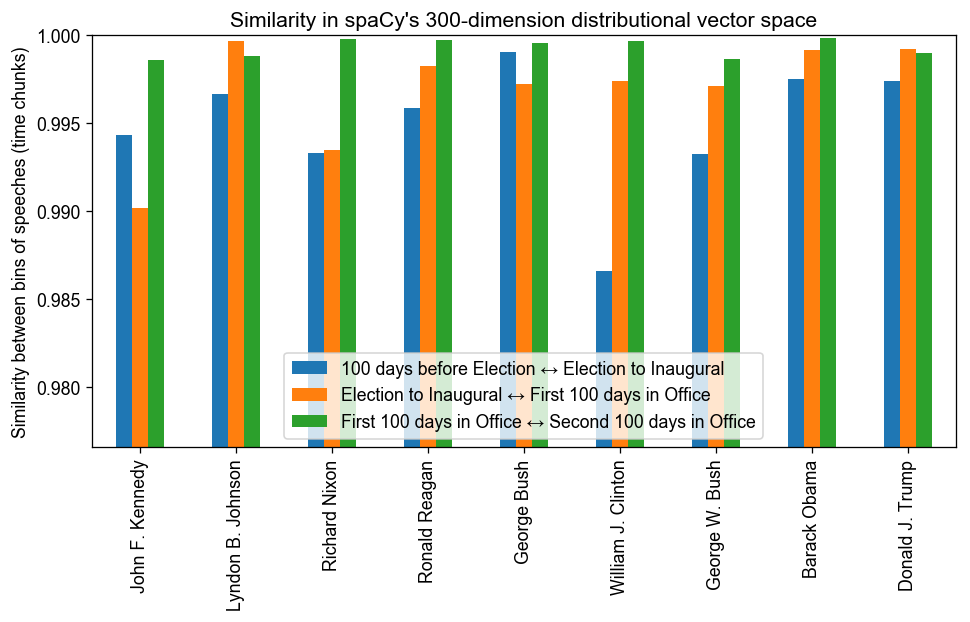

In [273]:
def _spacy_similarity(d1, d2): 
    return d1.document.similarity(d2.document)

def spacy_similarity_analyzer(bins):
    return iter_similarities(bins, simfunc=_spacy_similarity)
    
df_spacy = pd.DataFrame(create_bin_analysis_df(all_presidents_with_bins, spacy_similarity_analyzer)).set_index('name')

df = df_spacy
df.columns = pd.Index(list(df.columns), tupleize_cols=True)
df['analysis'].plot(kind='bar')
ymin = df['analysis'].min().min()
plt.ylim(ymin - 0.01, 1.0)
plt.xlabel('')
plt.xticks(rotation=90)
plt.legend(loc='lower center')
plt.ylabel('Similarity between bins of speeches (time chunks)')
plt.title("Similarity in spaCy's 300-dimension distributional vector space")
plt.tight_layout()
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-spacy-similarity.pdf')

## LIWC Categorical-Dynamic Index

In [278]:
def cdi_analyzer(bins):
    for doc in bins:
        token_counts = spacy_token_counts(doc.document)
        yield doc.title, cdi(token_counts)

df_cdi = pd.DataFrame(create_bin_analysis_df(all_presidents_with_bins, cdi_analyzer)).set_index('name')

In [279]:
df = df_cdi
df.columns = pd.Index(list(df.columns), tupleize_cols=True)

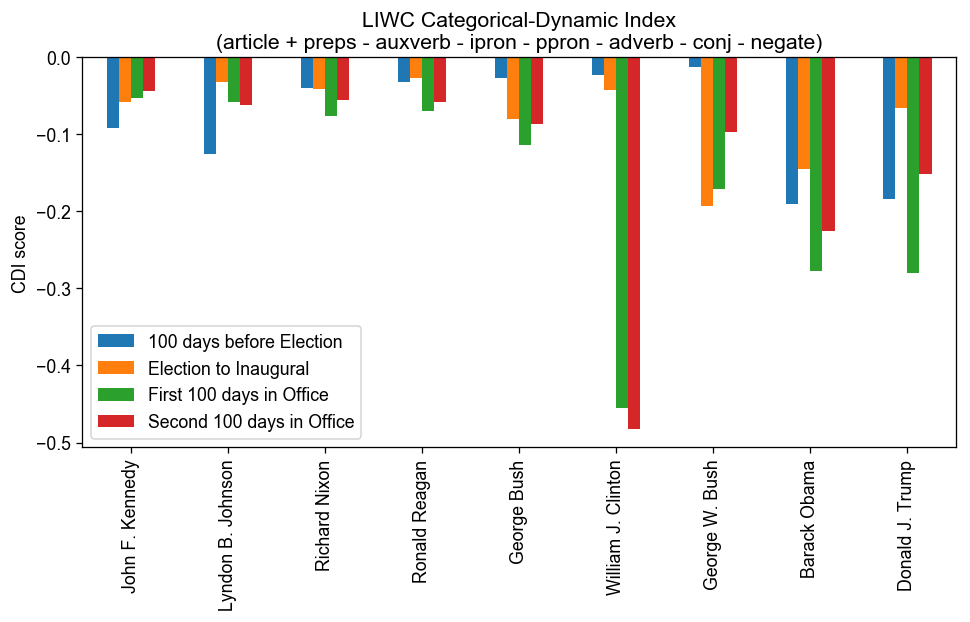

In [280]:
df['analysis'].plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('CDI score')
plt.title('LIWC Categorical-Dynamic Index\n(article + preps - auxverb - ipron - ppron - adverb - conj - negate)')
plt.tight_layout()
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-CDI.pdf')

#### DataFrame with bin stats

In [281]:
df

100 days before Election         Election to Inaugural  \
                                      #docs  #words                 #docs   
name                                                                        
John F. Kennedy                         583  815386                     1   
Lyndon B. Johnson                       284  433273                    81   
Richard Nixon                            25   69140                     2   
Ronald Reagan                             8   28756                    27   
George Bush                               3   11805                    12   
William J. Clinton                        1     958                     6   
George W. Bush                            1    5287                    31   
Barack Obama                            144  264990                    80   
Donald J. Trump                          64  235682                    25   

                           First 100 days in Office           \
                    #words                    #docs   #words   
name                                                           
John F. Kennedy       1568                      151   202131   
Lyndon B. Johnson    91116                      188   216130   
Richard Nixon         2654                      171   187876   
Ronald Reagan        22447                      357   204410   
George Bush          57389                      368   362987   
William J. Clinton    9524                      423  1076509   
George W. Bush      312560                      375   358554   
Barack Obama        259069                      304   623523   
Donald J. Trump      27903                      232   462296   

                   Second 100 days in Office           \
                                       #docs   #words   
name                                                    
John F. Kennedy                          158   117417   
Lyndon B. Johnson                        185   216755   
Richard Nixon                            143   154281   
Ronald Reagan                            329   183443   
George Bush                              429   362302   
William J. Clinton                       485  1186575   
George W. Bush                           369   357647   
Barack Obama                             335   530682   
Donald J. Trump                          267   294674   

                                   analysis                        \
                   100 days before Election Election to Inaugural   
name                                                                
John F. Kennedy                   -0.092018             -0.058394   
Lyndon B. Johnson                 -0.125354             -0.031933   
Richard Nixon                     -0.039837             -0.041379   
Ronald Reagan                     -0.032389             -0.026336   
George Bush                       -0.026224             -0.080030   
William J. Clinton                -0.023179             -0.042996   
George W. Bush                    -0.012146             -0.192986   
Barack Obama                      -0.190100             -0.145105   
Donald J. Trump                   -0.184375             -0.065890   

                                                                       \
                   First 100 days in Office Second 100 days in Office   
name                                                                    
John F. Kennedy                   -0.053307                 -0.043229   
Lyndon B. Johnson                 -0.058166                 -0.061899   
Richard Nixon                     -0.075833                 -0.055833   
Ronald Reagan                     -0.069093                 -0.058214   
George Bush                       -0.114365                 -0.087021   
William J. Clinton                -0.455715                 -0.482169   
George W. Bush                    -0.171094                 -0.097164   
Barack Obama                      -0.277801                 -0.225965   
Donald J

## LIWC Inter-bin Similarity

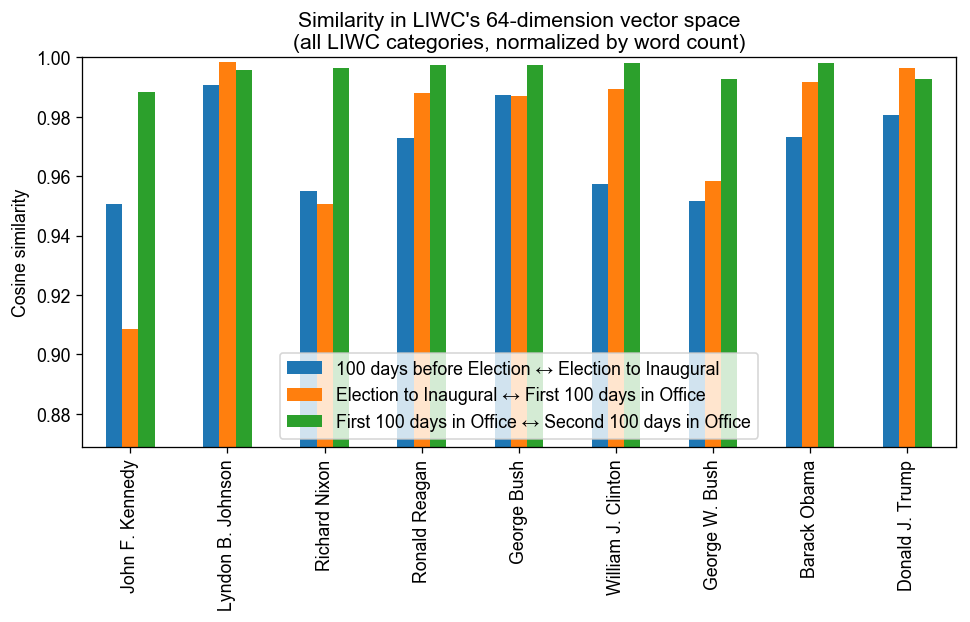

In [274]:
def _liwc_scores(titled_document):
    token_counts = spacy_token_counts(titled_document.document)
    return liwc_scores(token_counts)

def _liwc_similarity(d1, d2):
    liwc1 = _liwc_scores(d1)
    values1 = [liwc1[k] for k in liwc_category_names] 
    liwc2 = _liwc_scores(d2)
    values2 = [liwc2[k] for k in liwc_category_names] 
    return 1 - spatial.distance.cosine(values1, values2)

def liwc_similarity_analyzer(bins):
    return iter_similarities(bins, simfunc=_liwc_similarity)
    
df_liwc_similarity = pd.DataFrame(create_bin_analysis_df(all_presidents_with_bins, liwc_similarity_analyzer)).set_index('name')

df = df_liwc_similarity
df.columns = pd.Index(list(df.columns), tupleize_cols=True)
df['analysis'].plot(kind='bar')
ymin = df['analysis'].min().min()
plt.ylim(ymin - 0.04, 1.0)
plt.xlabel('')
plt.ylabel('Cosine similarity')
plt.xticks(rotation=90)
plt.legend(loc='lower center')
plt.title("Similarity in LIWC's 64-dimension vector space\n(all LIWC categories, normalized by word count)")
plt.tight_layout()
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-liwc-similarity.pdf')